In [1]:
import os
import cv2
import matlab.engine
import scipy.io
import scipy.misc
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.image import extract_patches_2d

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Stage 1 Feature extraction

In [2]:
#Read image and prepere file for matlab script
target = './images/motion0076.jpg'
im_name = target.split('/')[-1].split('.')[0]
image = scipy.misc.imread(target)
image_double = image/255.0
scipy.io.savemat('./feature_extraction/'+im_name+'.mat',{'im':image_double})

In [3]:
# Matlab eng start
# http://www.mathworks.com/help/matlab/matlab-engine-for-python.html
eng = matlab.engine.start_matlab()
eng.addpath('feature_extraction/feature')
eng.addpath('feature_extraction',nargout=0)

In [4]:
# Extract features by Matlab script (data is transported through *.mat files)
features = dict()
for patch_size in [11,15,21]:
    print('Scale '+str(patch_size)+' features extraction')
    eng.extract_features(im_name,patch_size,nargout=0)
    features[patch_size] = scipy.io.loadmat('./features.mat')
    del features[patch_size]['__version__']
    del features[patch_size]['__header__']
    del features[patch_size]['__globals__']
os.remove('./features.mat')
os.remove('./feature_extraction/'+im_name+'.mat')
print('Done')

Scale 11 features extraction
Scale 15 features extraction
Scale 21 features extraction
Done


In [5]:
# Matlab eng stop
eng.quit()

In [6]:
features[11]['GHS'].shape

(630, 360)

In [7]:
features[15]['GHS'].shape

(626, 356)

In [8]:
features[21]['GHS'].shape

(620, 350)

# Stage 2 Solid color areas

In [9]:
FIRST_KERNEL_SIZE = 11
SECOND_KERNEL_SIZE = 5
N_COLOURS = 8
THRESHOLD = 0.0001

In [10]:
image = image[12:-12,12:-12,:]

In [11]:
image.shape

(616, 346, 3)

In [12]:
def get_kernel(size):
    return np.ones((size,size),np.float32)/(size**2)

In [13]:
def reduce_color_count(image,n_colours):
    im_heigth = image.shape[0]
    im_width = image.shape[1]
    KM = KMeans(n_clusters=n_colours,init='k-means++')
    image2 = KM.fit_predict(image.reshape((im_heigth*im_width,image.shape[2])))
    image2 = np.array(list(map(lambda x: KM.cluster_centers_[x],image2)))
    image2 = image2.reshape((im_heigth,im_width,3))
    return 255 - image2.astype(int)

In [14]:
first_kernel = get_kernel(FIRST_KERNEL_SIZE)
second_kernel = get_kernel(SECOND_KERNEL_SIZE)
clustered_image = reduce_color_count(image,N_COLOURS)    
blurred_clustered_image = cv2.filter2D(clustered_image,-1,first_kernel)
clustered_images_difference = (np.sum((np.abs(clustered_image - blurred_clustered_image))/3.0,axis=2)).astype(float)
#smoothing
solid_color_areas  = cv2.filter2D(clustered_images_difference,-1,second_kernel)
#normalisation
solid_color_areas = (solid_color_areas - np.min(solid_color_areas))/np.max(solid_color_areas)
#edges restoration
solid_color_areas = 1-np.arctan(solid_color_areas/THRESHOLD)

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

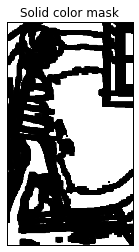

In [15]:
plt.imshow(solid_color_areas,cmap='gray')
plt.title('Solid color mask')
plt.xticks([]), plt.yticks([])